In [ ]:
#Latency of image arrival at USDF after shutter close on LSSTCam

In [1]:
from lsst.daf.butler import Butler
from lsst.daf.butler.registry import Registry
import sqlalchemy
from astropy import time


repo = 'embargo_new'
instrument = 'LSSTCam'
# raw all collection contains all images 
collections = [f'{instrument}/raw/all']
butler = Butler(repo, collections=collections, instrument=instrument)

# Data transferred and ingested in butler and access to data



In [3]:
dt = 'raw'
day = "20240926"
where = f"exposure.day_obs = {day}"
datasetRefs = list(butler.registry.queryDatasets(datasetType=dt,where=where))

print(f"There are {len(datasetRefs)} {dt} in collection: {collections} in: {repo} for {where}")

count = 0
for ref in datasetRefs[0], datasetRefs[-1]:
    count = count + 1
    print( ref.dataId['detector'], ref.dataId['exposure'])

There are 329557 raw in collection: ['LSSTCam/raw/all'] in: embargo_new for exposure.day_obs = 20240926
191 2024092600001
104 2024092601583


In [6]:
# Make a map of thoose for look up below .. 
dslookup = {}
for ref in datasetRefs:
    dslookup[ref.dataId['exposure']] = ref

### latency ..
"Measure the delays between completion of readout for each image and the ingestion time recorded in the Butler Registry."
The end of readout is the exposure.timespan.end.
Will have to lookup the ingest time using a sql query since is not exposed directly in butler.

In [7]:
res = butler.registry.queryDimensionRecords('exposure', where=where, instrument=instrument)
print (f"Got Metadata for {res.count()} exposures")
times = []
min = 100
max = 0
for count, dimensionRecord in enumerate(res):
    datasetRef = dslookup[dimensionRecord.id]
    uuid = datasetRef.id
    # the ID in the dimension record is the exposure ID (dimensionRecord.id)
    # the ID in the embargo.dataset is the UUID from the datasetRef 
    # hence the lookup map created in the cell above is used here to lookup the UUID
    
    q_string = f"SELECT ingest_date FROM embargo.dataset WHERE id='{uuid}'"
    with butler.registry._registry._db.query(sqlalchemy.text(q_string)) as q:
        intime = time.Time(q.all()[0][0])
        
    diff = (intime - dimensionRecord.timespan.end ).to('minute')
    if diff.value < min:
        min = diff.value
    if diff.value > max:
        max = diff.value 
    #print(r.id,r.timespan.end, intime, diff )
    times.append(diff.value)
    
import numpy as np
print (f"The min time was {min} max time was {max} minutes")
print (f"Time between shutter close and ingest mean:{np.mean(times)}, std:{np.std(times)}, var:{np.var(times)} minutes")

Got Metadata for 1610 exposures
The min time was 0.29279703333340734 max time was 8.60558226666674 minutes
Time between shutter close and ingest mean:5.187649398954476, std:2.7631875881283365, var:7.635205647186495 minutes


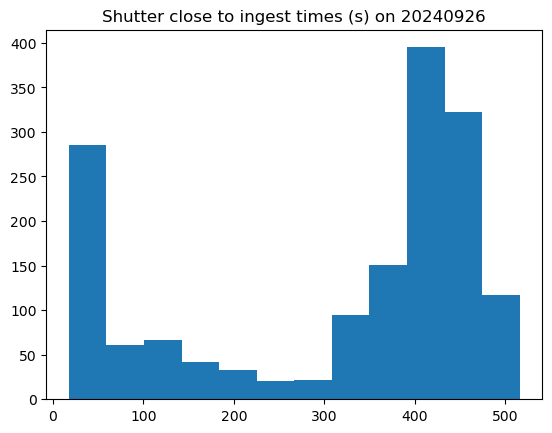

In [8]:
import matplotlib.pyplot as plt
seconds = list(map(lambda t:t*60.0,times))
plt.hist(seconds,bins='auto')
plt.title(f"Shutter close to ingest times (s) on {day}")
plt.show()